<a href="https://colab.research.google.com/github/ElTrulul/PneumoniaScans/blob/master/ChestXRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil

In [ ]:
basedir = '/content/chest_xray'
traindir = os.path.join(basedir, 'train')
testdir = os.path.join(basedir,'test')

In [ ]:

try:
  shutil.rmtree(basedir)
  shutil.rmtree('/content/__MACOSX')
except:
  print('Nothing to delete')

## Getting and Unzipping Data from Mendeley


In [ ]:
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip

--2020-08-07 15:34:23--  https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2020-08-07 15:34:24--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.91.40
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.91.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512464 (1.2G) [application/zip]
Sa

In [ ]:
!unzip ChestXRay2017.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1597_bacteria_4192.jpeg  
  inflating: ch

In [ ]:
os.remove('ChestXRay2017.zip')

### Path Definitions and Totals

In [ ]:
TRAIN_NO_COUNT = len(os.listdir(os.path.join(traindir,'NORMAL')))
TRAIN_PN_COUNT = len(os.listdir(os.path.join(traindir,'PNEUMONIA')))
TRAIN_COUNT = TRAIN_NO_COUNT + TRAIN_PN_COUNT
TEST_NO_COUNT = len(os.listdir(os.path.join(testdir,'NORMAL')))
TEST_PN_COUNT = len(os.listdir(os.path.join(testdir,'PNEUMONIA')))
TEST_COUNT = TEST_NO_COUNT + TEST_PN_COUNT
print(f'Normal images totals in training set: {TRAIN_NO_COUNT}')
print(f'Pneumonia images totals in training set: {TRAIN_PN_COUNT}')
print(f'Normal images totals in test set: {TEST_NO_COUNT}')
print(f'Pneumonia images totals in test set: {TEST_PN_COUNT}')

Normal images totals in training set: 1349
Pneumonia images totals in training set: 3884
Normal images totals in test set: 234
Pneumonia images totals in test set: 390


There are roughly three times as many pneumonia pictures than normal pictures in the training set. Hence the model should pay more attention on normal pictures during the fitting process. This will be done in the "Balance Data" section.

### Print Sample X-Ray

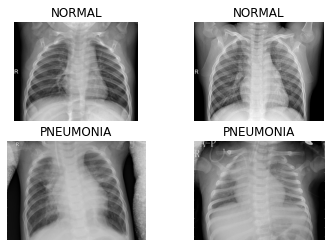

In [ ]:
normalsample = random.sample(os.listdir(os.path.join(traindir,'NORMAL')),2)
pnsample = random.sample(os.listdir(os.path.join(traindir,'PNEUMONIA')),2)
fig, ax = plt.subplots(2,2)
for i in range(4):
  if i < 2:
    ax[i//2, i%2].imshow(Image.open(os.path.join(traindir,'NORMAL',normalsample[i])), cmap='gray')
    ax[i//2, i%2].set_title("NORMAL")
  else:
    ax[i//2, i%2].imshow(Image.open(os.path.join(traindir,'PNEUMONIA',pnsample[i-2])), cmap='gray')
    ax[i//2, i%2].set_title("PNEUMONIA")
  ax[i//2, i%2].axis('off')

plt.savefig('sample.png', transparent=True)  
plt.show()


## Model Setup (Transfer Learning from InceptionV3)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dropout(0.4)(x)                  
x = tf.keras.layers.Dense  (1, activation='sigmoid')(x)           
 
model = tf.keras.Model(pre_trained_model.input, x) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

## Image Data Generator

As the XRay pictures are always taken from the same angle, we will use just a simple data augmentation approach.

In [ ]:
TRAIN_BATCH_SIZE = 80
TEST_BATCH_SIZE = 50

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=(0.2,0.5),
                                   rotation_range=35,
                                   zoom_range=0.2,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
train_gen = train_datagen.flow_from_directory(traindir, 
                                              batch_size=TRAIN_BATCH_SIZE, 
                                              target_size=(150,150),
                                              class_mode='binary')
test_gen = test_datagen.flow_from_directory(testdir,
                                            batch_size=TEST_BATCH_SIZE,
                                            target_size=(150,150),
                                            class_mode='binary')

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Balance Data

In [ ]:
weight_for_0 = (1 / TRAIN_NO_COUNT)*(TRAIN_COUNT)/2.0 
weight_for_1 = (1 / TRAIN_PN_COUNT)*(TRAIN_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 1.94
Weight for class 1: 0.67


## Callbacks

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
    print(f"- lr: {lr}")
    if logs.get('accuracy')>0.99:
      print('Accuracy > 99% reached!')
      self.model.stop_training=True
 
        
callback = myCallback()

In [ ]:
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0*0.1**(epoch / s)
  return exponential_decay_fn
exponential_decay_fn = exponential_decay(lr0=0.001, s=20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## Fitting the Model

In [ ]:
history = model.fit(train_gen,
                    validation_data = test_gen,
                    epochs=60,
                    verbose=1, 
                    steps_per_epoch=TRAIN_COUNT // TRAIN_BATCH_SIZE,
                    validation_steps=TEST_COUNT // TEST_BATCH_SIZE,
                    callbacks=[callback, lr_scheduler],
                    class_weight=class_weight)

Epoch 1/60
65/65 [==============================] - 82s 1s/step - loss: 0.3105 - accuracy: 0.8589 - recall: 0.8547 - precision: 0.9503 - val_loss: 0.2630 - val_accuracy: 0.8833 - val_recall: 0.8827 - val_precision: 0.9272
Epoch 2/60
65/65 [==============================] - 79s 1s/step - loss: 0.1860 - accuracy: 0.9253 - recall: 0.9202 - precision: 0.9778 - val_loss: 0.2322 - val_accuracy: 0.8967 - val_recall: 0.8989 - val_precision: 0.9337
Epoch 3/60
65/65 [==============================] - 79s 1s/step - loss: 0.1646 - accuracy: 0.9328 - recall: 0.9270 - precision: 0.9815 - val_loss: 0.2367 - val_accuracy: 0.9283 - val_recall: 0.9787 - val_precision: 0.9129
Epoch 4/60
65/65 [==============================] - 80s 1s/step - loss: 0.1607 - accuracy: 0.9361 - recall: 0.9328 - precision: 0.9802 - val_loss: 0.2114 - val_accuracy: 0.9133 - val_recall: 0.9340 - val_precision: 0.9291
Epoch 5/60
65/65 [==============================] - 80s 1s/step - loss: 0.1457 - accuracy: 0.9427 - recall: 0.94

## Model Evaluation

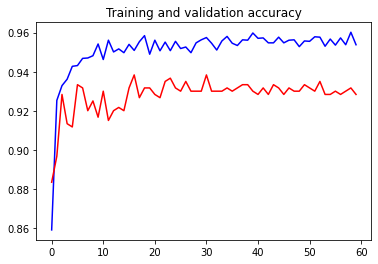

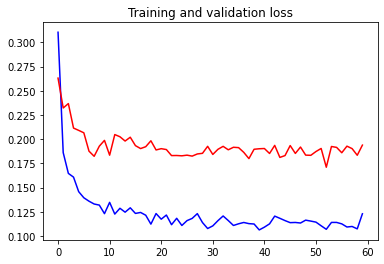

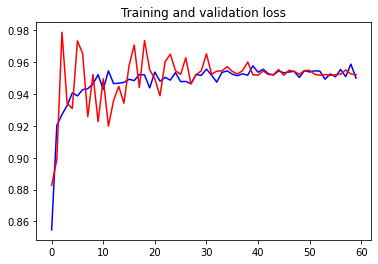

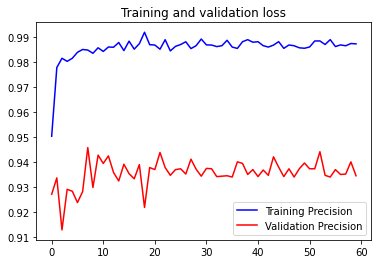

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']
precision = history.history['precision']
val_precision = history.history['val_precision']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
 
plt.figure()
 
plt.plot(epochs, recall, 'b', label='Training Recall')
plt.plot(epochs, val_recall, 'r', label='Validation Recall')
plt.title('Training and validation loss')
 
plt.figure()
 
plt.plot(epochs, precision, 'b', label='Training Precision')
plt.plot(epochs, val_precision, 'r', label='Validation Precision')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()